# System

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os 
os.getcwd()

'/content'

# Libraries

In [ ]:
import numpy as np
import pandas as pd

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt
import time
import copy
from random import shuffle

import tqdm.notebook as tqdm

import sklearn
from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.metrics import classification_report
from PIL import Image
import cv2

import os
import shutil

# GPU

In [ ]:
# setting device on GPU if available, else CPU
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device("cuda")
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

Tesla K80
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [ ]:
if torch.cuda.is_available():
    device=torch.device("cuda:0")
    print("Training on GPU... Ready for HyperJump...")
else:
    device = torch.device("cpu")
    print("Training on CPU... May the force be with you...")

Training on GPU... Ready for HyperJump...


In [ ]:
torch.cuda.is_available()

True

# PATHS

In [ ]:
DATA_PATH = '/content/drive/MyDrive/chest_xray'
print("DATA_PATH = ",DATA_PATH)

TRAIN_PATH = os.path.join(DATA_PATH, "train/")
print("TRAIN_PATH = ", TRAIN_PATH)

VAL_PATH = os.path.join(DATA_PATH, "test/")
print("TEST_PATH = ",VAL_PATH)

DATA_PATH =  /content/drive/MyDrive/chest_xray
TRAIN_PATH =  /content/drive/MyDrive/chest_xray/train/
TEST_PATH =  /content/drive/MyDrive/chest_xray/test/


# Plotting Distribution of Each Classes

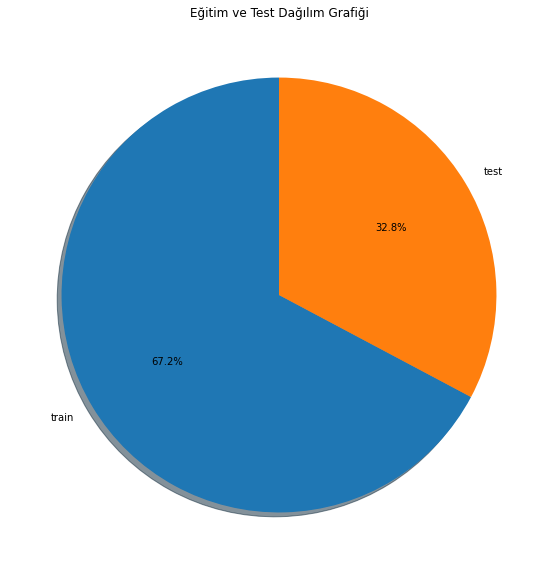

In [ ]:
# class_names = os.listdir(DATA_PATH)
class_name_train = os.listdir(TRAIN_PATH)
class_name_val = os.listdir(VAL_PATH)
image_count_train = {}
image_count_val = {}

for i in class_name_train:
    image_count_train[i] = len(os.listdir(os.path.join(TRAIN_PATH,i)))
    
for i in class_name_val:
    image_count_val[i] = len(os.listdir(os.path.join(VAL_PATH,i)))

# print(image_count_train)

sum_train_images = 0
for k,v in image_count_train.items():
    sum_train_images += v

# print(sum_train_images)

sum_val_images = 0
for k,v in image_count_val.items():
     sum_val_images += v

# print(sum_val_images)

image_count = {'train': sum_train_images, 'test': sum_val_images}

#Plotting Distribution of Each Classes
fig1, ax1 = plt.subplots(figsize=(10, 10), subplot_kw=dict(aspect="equal"))
ax1.pie(image_count.values(),
        labels = image_count.keys(),
        shadow=True,
        autopct = '%1.1f%%',
        startangle=90)
plt.title("Eğitim ve Test Dağılım Grafiği")
plt.show()


# Plotting Distribution of Train Classes

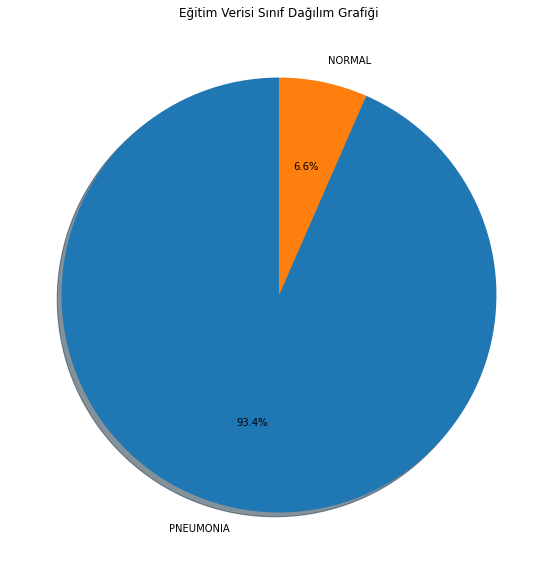

{'PNEUMONIA': 1196, 'NORMAL': 84}


In [ ]:
class_names = os.listdir(TRAIN_PATH)
image_count = {}
for i in class_names:
    image_count[i] = len(os.listdir(os.path.join(TRAIN_PATH,i)))

#Plotting Distribution of Each Classes
fig1, ax1 = plt.subplots(figsize=(10, 10), subplot_kw=dict(aspect="equal"))
ax1.pie(image_count.values(),
        labels = image_count.keys(),
        shadow=True,
        autopct = '%1.1f%%',
        startangle=90)
plt.title("Eğitim Verisi Sınıf Dağılım Grafiği")
plt.show()
print(image_count)

# Plotting Distribution of Test Classes

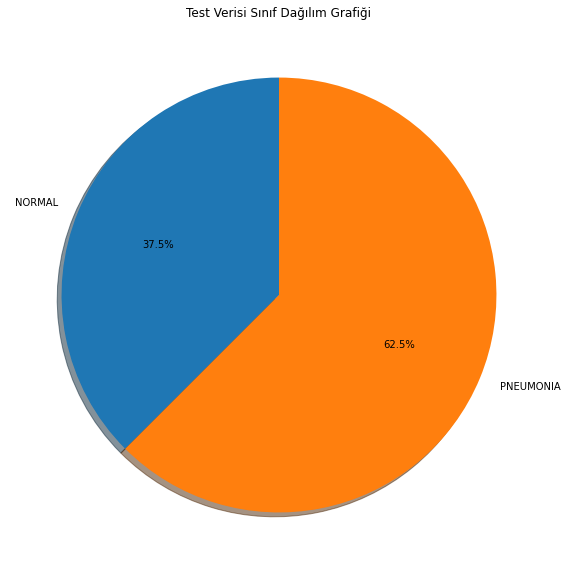

{'NORMAL': 234, 'PNEUMONIA': 390}


In [ ]:
class_names = os.listdir(VAL_PATH)
image_count = {}
for i in class_names:
    image_count[i] = len(os.listdir(os.path.join(VAL_PATH,i)))

#Plotting Distribution of Each Classes
fig1, ax1 = plt.subplots(figsize=(10, 10), subplot_kw=dict(aspect="equal"))
ax1.pie(image_count.values(),
        labels = image_count.keys(),
        shadow=True,
        autopct = '%1.1f%%',
        startangle=90)
plt.title("Test Verisi Sınıf Dağılım Grafiği")
plt.show()
print(image_count)

# Data Loading

In [ ]:
#Statistics Based on ImageNet Data for Normalisation
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

data_transforms = {"train":transforms.Compose([
                                transforms.Resize((224,224)), #Resizes all images into same dimension
                                transforms.ToTensor(), # Coverts into Tensors
                                transforms.Normalize(mean = mean_nums, std=std_nums)]), # Normalizes
                    "test": transforms.Compose([
                                transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=mean_nums, std = std_nums)
                    ])}


In [ ]:
def load_split_train_test(datadir, valid_size = .3):
    train_data = datasets.ImageFolder(datadir,       
                    transform=data_transforms['train']) #Picks up Image Paths from its respective folders and label them
    print(train_data)
    test_data = datasets.ImageFolder(datadir,
                    transform=data_transforms['test'])
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    train_idx, test_idx = indices[split:], indices[:split]
    dataset_size = {"train":len(train_idx), "val":len(test_idx)}
    train_sampler = SubsetRandomSampler(train_idx) # Sampler for splitting train and val images
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=16) # DataLoader provides data from traininng and validation in batches
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=16)
    return trainloader, testloader, dataset_size
trainloader, valloader, dataset_size = load_split_train_test(TRAIN_PATH, .3)
dataloaders = {"train":trainloader, "val":valloader}
data_sizes = {x: len(dataloaders[x].sampler) for x in ['train','val']}
class_names = trainloader.dataset.classes
print(data_sizes)
print(class_names)

# Dataset has 15886 data points.
# Train Dataset has 12708 data points
# Test Dataset has 3178 data points.

Dataset ImageFolder
    Number of datapoints: 1280
    Root location: /content/drive/MyDrive/chest_xray/train/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
{'train': 896, 'val': 384}
['NORMAL', 'PNEUMONIA']


# Visualization of Train Samples

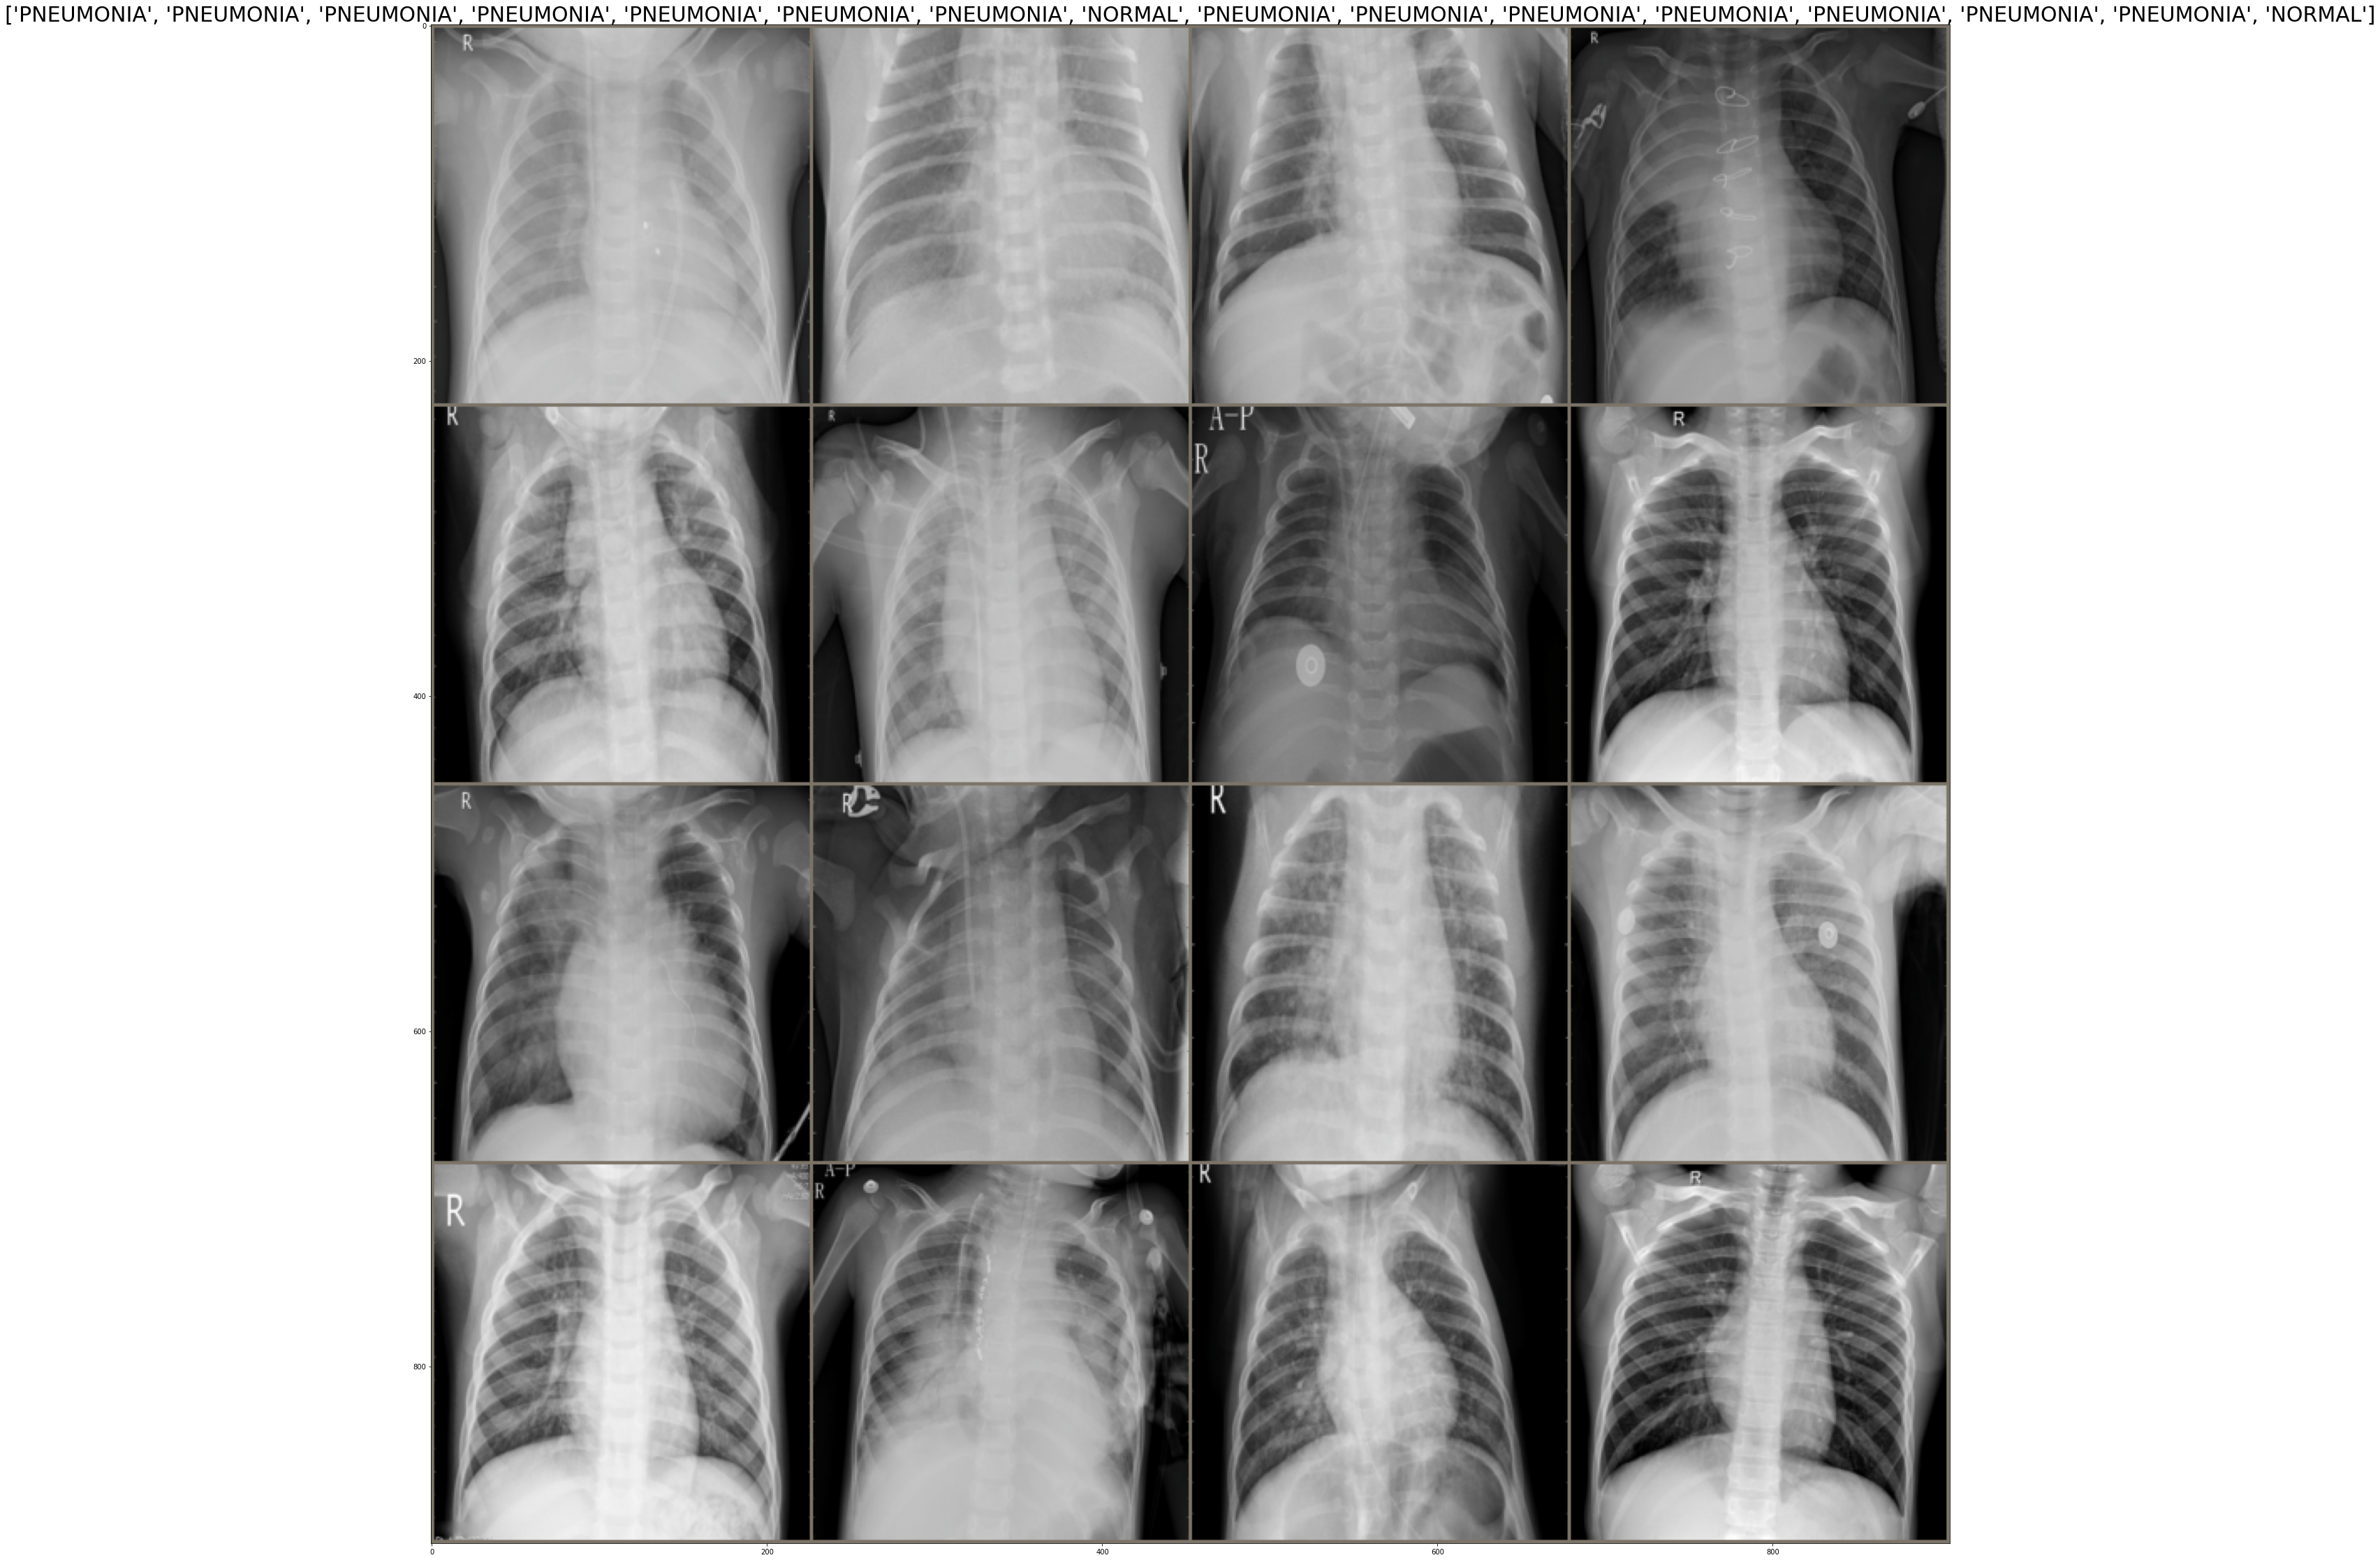

In [ ]:
import matplotlib
def imshow(inp, size =(40,40), title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = mean_nums
    std = std_nums
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=size)
    plt.imshow(inp)
    if title is not None:
        plt.title(title, size=30)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data

inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow =  4, padding =  2, value_range = 1)



imshow(out, title=[class_names[x] for x in classes])


# # Get a batch of val data

# inputs, classes = next(iter(dataloaders['val']))

# # Make a grid from batch
# out = torchvision.utils.make_grid(inputs)

# imshow(out, title=[class_names[x] for x in classes])


# All model variants

In [ ]:
def CNN_Model(pretrained=True):
    #model = models.densenet121(pretrained=pretrained) # Returns Defined Densenet model with weights trained on ImageNet
    model = models.alexnet(pretrained=pretrained)
    model.eval()
    return model

model = CNN_Model(pretrained=True)

# specify loss function (categorical cross-entropy loss)
criterion = nn.CrossEntropyLoss() 

# Specify optimizer which performs Gradient Descent
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=429, gamma=0.1) # Learning Scheduler

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [ ]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

# Training

In [ ]:
import math
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0
            current_kappa = 0
            val_kappa = list()

            for inputs, labels in tqdm.tqdm(dataloaders[phase], desc=phase, leave=False):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # We need to zero the gradients in the Cache.
                optimizer.zero_grad()

                # Time to carry out the forward training poss
                # We only need to log the loss stats if we are in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                if phase == 'train':
                    scheduler.step()

                # We want variables to hold the loss statistics
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)
                
                val_kappa.append(cohen_kappa_score(preds.cpu().numpy(), labels.data.cpu().numpy()))
                #print(val_kappa)
            epoch_loss = current_loss / data_sizes[phase]
            epoch_acc = current_corrects.double() / data_sizes[phase]
            if phase == 'val':
                epoch_kappa = np.mean(val_kappa)
                print('{} Loss: {:.4f} | {} Accuracy: {:.4f} | Kappa Score: {:.4f}'.format(
                    phase, epoch_loss, phase, epoch_acc, epoch_kappa))
            else:
                print('{} Loss: {:.4f} | {} Accuracy: {:.4f}'.format(
                    phase, epoch_loss, phase, epoch_acc))

            # EARLY STOPPING
            if phase == 'val' and epoch_loss < best_loss:
                print('Val loss Decreased from {:.4f} to {:.4f} \nSaving Weights... '.format(best_loss, epoch_loss))
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val loss: {:.4f}'.format(best_loss))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model.cuda()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
np.seterr(divide='ignore', invalid='ignore')
base_model = train_model(model, criterion, optimizer, exp_lr_scheduler,num_epochs=2)

Epoch 1/2
----------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.8821 | train Accuracy: 0.8940


val:   0%|          | 0/24 [00:00<?, ?it/s]

val Loss: 0.4653 | val Accuracy: 0.9297 | Kappa Score: nan
Val loss Decreased from inf to 0.4653 
Saving Weights... 

Epoch 2/2
----------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.2668 | train Accuracy: 0.9364


val:   0%|          | 0/24 [00:00<?, ?it/s]

val Loss: 0.2557 | val Accuracy: 0.9297 | Kappa Score: nan
Val loss Decreased from 0.4653 to 0.2557 
Saving Weights... 

Training complete in 1m 47s
Best val loss: 0.2557


In [ ]:
torch.save(model.state_dict(), "alexnet_chestxray.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


# Model Visualization

In [ ]:
def visualize_model(model, num_images=12):
    was_training = model.training
    model.eval()
    images_handeled = 0
    ax = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
    
            for j in range(inputs.size()[0]):
                images_handeled += 1    
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('Actual: {} Predicted: {}'.format(class_names[labels[j].item()],class_names[preds[j]]))
                imshow(inputs.cpu().data[j], (16,4))

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

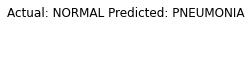

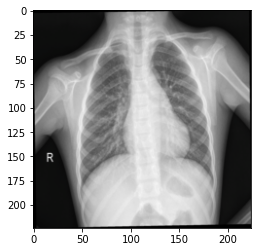

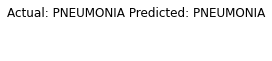

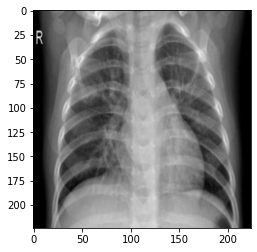

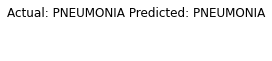

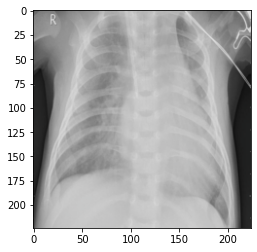

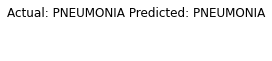

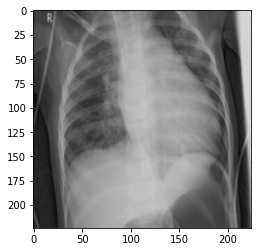

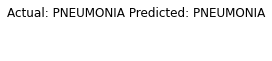

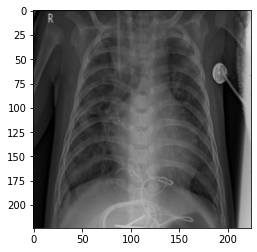

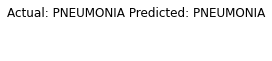

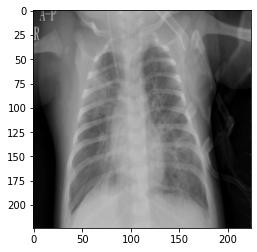

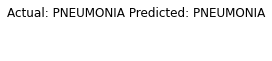

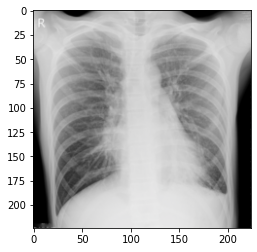

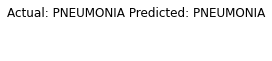

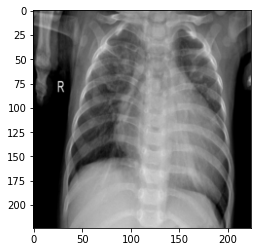

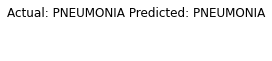

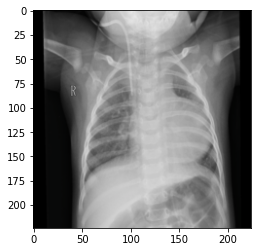

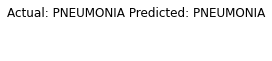

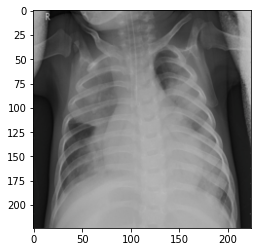

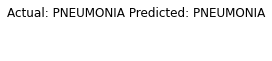

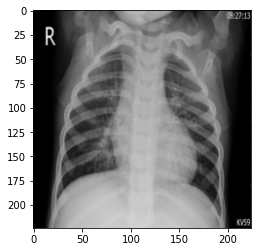

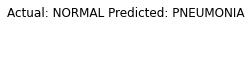

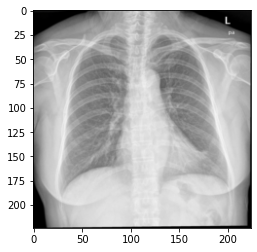

In [ ]:
visualize_model(base_model)
plt.show()

# Test Accuracy

In [ ]:
class_names

['NORMAL', 'PNEUMONIA']

In [ ]:
from sklearn.metrics import confusion_matrix
import torch.nn.functional as F

def test_model(model,dataloaders,device):
    CM=0
    model.eval()
    with torch.no_grad():
        #for data in dataloaders['test']:
        i=0
        j=0
        sumtp, sumfp, sumfn, sumfp = 0, 0, 0, 0
        for data in dataloaders['val']:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images) #file_name
            preds = torch.argmax(outputs.data, 1)
            CM+=confusion_matrix(labels.cpu(), preds.cpu(),labels=[0, 1 ])

        tp=CM[1][1]
        fp=CM[0][1]
        fn=CM[1][0]
        acc=np.sum(np.diag(CM)/np.sum(CM))
        recall=sumtp/(sumtp+sumfn)
        precision=sumtp/(sumtp+sumfp)
        print('\nTestset Accuracy(mean): %f %%' % (100 * acc))
        #print('- NPV: ',(tn/(tn+fn))*100
        return acc, CM

    

In [ ]:
acc, cm = test_model(model,dataloaders,device)
print(cm)
print("Accuracy",acc)

sumfn [27, 0]
fparray [0, 27]
sumfp 27
sumfn 27
sumtp 357

Testset Accuracy(mean): 92.968750 %
- Recall :  92.96875
- Precision:  92.96875
- F1 Score:  92.96875
[[  0  27]
 [  0 357]]
Accuracy 0.9296875


In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
class_names

['NORMAL', 'PNEUMONIA']

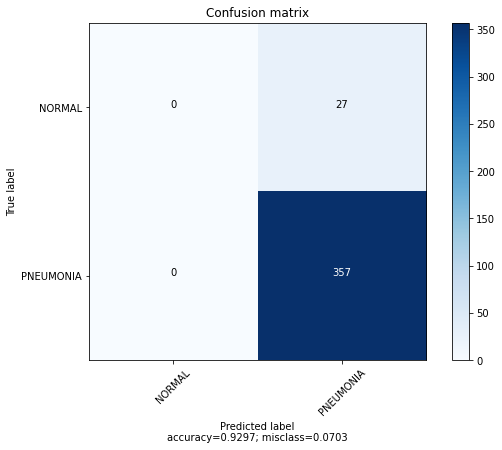

In [ ]:
from sklearn import metrics
plot_confusion_matrix(cm, target_names= ['NORMAL', 'PNEUMONIA'], title='Confusion matrix' , normalize=False)